In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image

c:\Users\Bastien Faivre\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import *
from utils import *
from model import UNET

In [3]:
IMAGE_HEIGHT = 400
IMAGE_WIDTH = 400
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
TRAIN_IMAGE_DIR = "train_data/train_images/"
TRAIN_GROUNDTRUTH_DIR = "train_data/train_masks/"
VAL_IMAGE_DIR = "train_data/val_images/"
VAL_GROUNDTRUTH_DIR = "train_data/val_masks/"
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
NUM_EPOCHS = 20

In [4]:
# define transformations
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [5]:
# create model
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
# define loss function, optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
# load data
train_loader, val_loader = get_loaders(
    TRAIN_IMAGE_DIR,
    TRAIN_GROUNDTRUTH_DIR,
    VAL_IMAGE_DIR,
    VAL_GROUNDTRUTH_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY
)

In [7]:
# compute F1 score
def f1_score(preds, target, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    target = target.float()
    intersection = (preds * target).sum((1, 2))
    union = (preds + target).sum((1, 2))
    return ((2. * intersection + eps) / (union + eps)).mean()

In [8]:
def train_epoch(model, optimizer, criterion, train_loader, epoch, device):
    model.train()
    train_loss = 0
    train_f1 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        _, predictions_sig = model(data)
        loss = criterion(predictions_sig, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_f1 += f1_score(predictions_sig, target)
    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)
    print('Train set: Average loss: {:.4f}\tAverage F1: {:.4f}'.format(train_loss, train_f1))
    return train_loss, train_f1

In [9]:
@torch.no_grad()
def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    val_f1 = 0
    for data, target in val_loader:
        data, target = data.to(device), target.float().unsqueeze(1).to(device)
        _, predictions_sig = model(data)
        val_loss += criterion(predictions_sig, target).item()
        val_f1 += f1_score(predictions_sig, target)
    val_loss /= len(val_loader)
    val_f1 /= len(val_loader)
    print('Validation set: Average loss: {:.4f}\tAverage F1: {:.4f}'.format(val_loss, val_f1))
    model.train()
    return val_loss, val_f1

In [10]:
# train model

train_loss_history = []
train_f1_history = []
val_loss_history = []
val_f1_history = []

for epoch in range(NUM_EPOCHS):

    train_loss, train_f1 = train_epoch(model, optimizer, criterion, train_loader, epoch, DEVICE)

    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)

    val_loss, val_f1 = validate(model, criterion, val_loader, DEVICE)

    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    
    save_checkpoint(checkpoint)

    save_predictions_as_imgs(
        val_loader, model, folder="saved_images/", device=DEVICE
    )

Train set: Average loss: 0.8418	Average F1: 0.3819
Validation set: Average loss: 0.9275	Average F1: 0.3003
=> Saving checkpoint
Train set: Average loss: 0.8036	Average F1: 0.4342
Validation set: Average loss: 0.9045	Average F1: 0.3744
=> Saving checkpoint
Train set: Average loss: 0.7807	Average F1: 0.4941
Validation set: Average loss: 0.7689	Average F1: 0.5682
=> Saving checkpoint
Train set: Average loss: 0.7607	Average F1: 0.5925
Validation set: Average loss: 0.7380	Average F1: 0.4468
=> Saving checkpoint
Train set: Average loss: 0.7518	Average F1: 0.5683
Validation set: Average loss: 0.7350	Average F1: 0.5466
=> Saving checkpoint
Train set: Average loss: 0.7430	Average F1: 0.6131
Validation set: Average loss: 0.7350	Average F1: 0.4458
=> Saving checkpoint
Train set: Average loss: 0.7366	Average F1: 0.6316
Validation set: Average loss: 0.7268	Average F1: 0.6235
=> Saving checkpoint
Train set: Average loss: 0.7325	Average F1: 0.6216
Validation set: Average loss: 0.7235	Average F1: 0.67

In [11]:
torch.cuda.empty_cache()

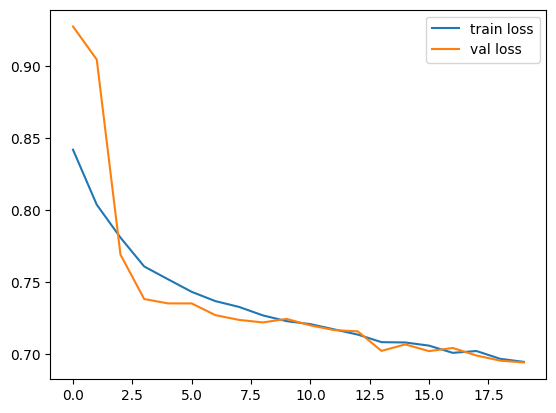

In [12]:
# plot loss and F1 score
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.show()